# BooksNN - Average Trends from CSV - Evaluate seasonality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyisbn #module for converting ISBN-13 to ISBN-10 and vice versa
import booksnn as bnn

## Load data - average trends
Either load from database, or load average trends from csv. 
Warning: If reading from database, this could take some time. 500 ASINs already takes several minutes. 

In [2]:
## LOAD single year trends from csv
up = pd.read_csv('./stats/usedprice_stats_2020_12_05.csv',index_col='index',parse_dates=True)
uc = pd.read_csv('./stats/usedcount_stats_2020_12_05.csv',index_col='index',parse_dates=True)
sr = pd.read_csv('./stats/salesrank_stats_2020_12_05.csv',index_col='index',parse_dates=True)

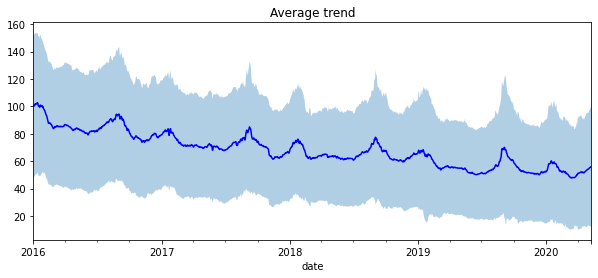

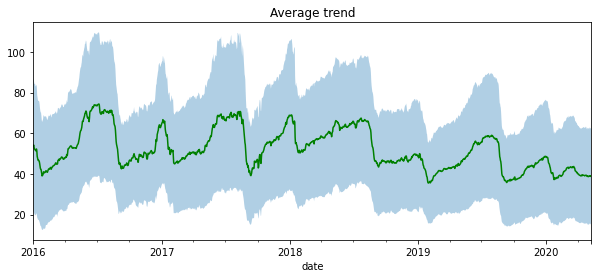

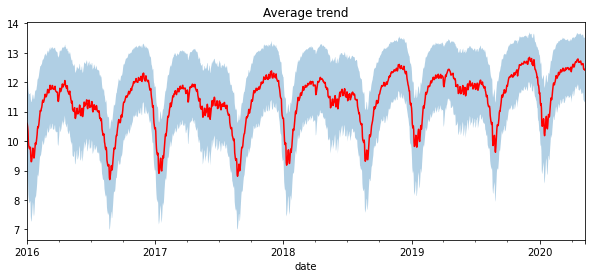

In [3]:
bnn.plot_average(up,from_stats=True)
bnn.plot_average(uc,from_stats=True,plot_color='green')
bnn.plot_average(sr,from_stats=True,plot_color='red')

## Evaluate linear trend
Used price has a steady downward trend. What's the avg % change year to year?

note: How to convert posixtime back into dataframe:
_pd.DataFrame([pd.to_datetime(i) for i in t])_

Dollars per year loss in value: [-8.93789602]
Used offer count change per year: [-3.25127485]
Log salesrank change per year: [0.28238738]


 DETRENDED AVERAGE SERIES:


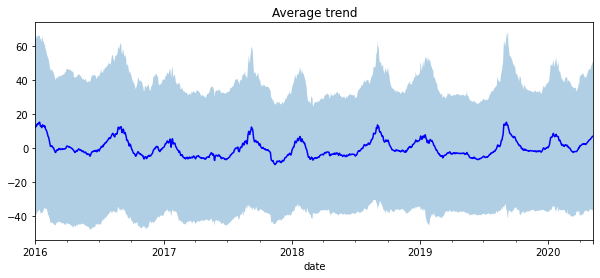

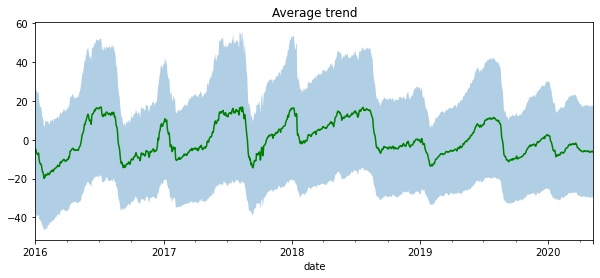

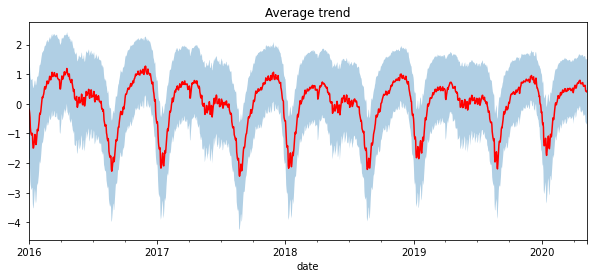

In [4]:
from sklearn.linear_model import LinearRegression

t_up = pd.to_datetime(up.index, format='%Y-%m-%d').to_numpy().astype(np.int64).reshape(-1,1) 

reg_up = LinearRegression().fit(t_up,up['mean'])
print('Dollars per year loss in value: ' + str(reg_up.coef_*10**9*60*60*24*365))
# $/ns * 1e9ns/s * 60s/min * 60min/hr * 24hrs/day * 365days/yr
#reg.intercept_

up_detrended = up
up_detrended['mean'] = up['mean'] - reg_up.predict(t_up)

reg_uc = LinearRegression().fit(t_up,uc['mean'])
print('Used offer count change per year: ' + str(reg_uc.coef_*10**9*60*60*24*365))
uc_detrended = uc
uc_detrended['mean'] = uc['mean'] - reg_uc.predict(t_up)

reg_sr = LinearRegression().fit(t_up,sr['mean'])
print('Log salesrank change per year: ' + str(reg_sr.coef_*10**9*60*60*24*365))
sr_detrended = sr
sr_detrended['mean'] = sr['mean'] - reg_sr.predict(t_up)

print('\n\n DETRENDED AVERAGE SERIES:')

bnn.plot_average(up_detrended,from_stats=True)
bnn.plot_average(uc_detrended,from_stats=True,plot_color='green')
bnn.plot_average(sr_detrended,from_stats=True,plot_color='red')


### Normalize series

Zero center and unit variance.

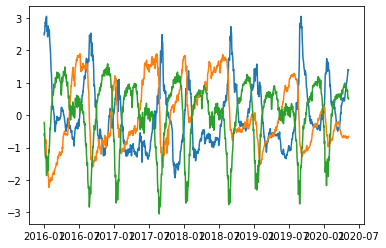

In [5]:
up_norm = (up_detrended['mean'] - np.mean(up_detrended['mean']))/(np.std(up_detrended['mean']))
uc_norm = (uc_detrended['mean'] - np.mean(uc_detrended['mean']))/(np.std(uc_detrended['mean']))
sr_norm = (sr_detrended['mean'] - np.mean(sr_detrended['mean']))/(np.std(sr_detrended['mean']))

plt.plot(up_norm)
plt.plot(uc_norm)
plt.plot(sr_norm)

## Plot ideal seasonality
### Calculate average yearly behavior

In [6]:
# Getting averages across time is super easy using pandas! Amazing!
up_year = up_norm.groupby(up_norm.index.dayofyear).mean()
uc_year = uc_norm.groupby(uc_norm.index.dayofyear).mean()
sr_year = sr_norm.groupby(sr_norm.index.dayofyear).mean()

Text(0.5, 1.0, 'Salesrank, average yearly behavior')

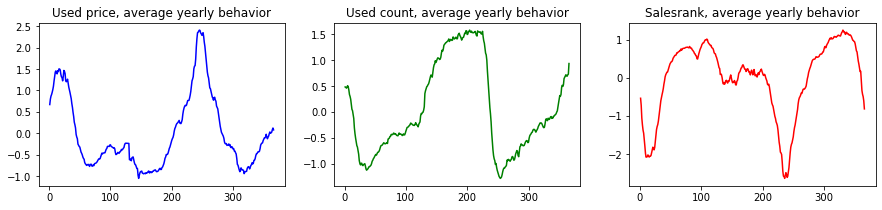

In [7]:
# Plot next to each other
fig = plt.figure(figsize=(15,3))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(up_year,color='blue')
ax1.set_title('Used price, average yearly behavior')

ax2 = plt.subplot(1, 3, 2)
ax2.plot(uc_year,color='green')
ax2.set_title('Used count, average yearly behavior')

ax3 = plt.subplot(1, 3, 3)
ax3.plot(sr_year,color='red')
ax3.set_title('Salesrank, average yearly behavior')

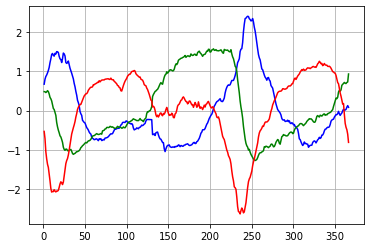

In [8]:
# Plot on top of each other
plt.plot(up_year,color='blue')
plt.plot(uc_year,color='green')
plt.plot(sr_year,color='red')
plt.grid()

## Seasonal decomposition using statsmodels

Another way to get an average - then need to compare them. 

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Idea for how to proceed with individual series: quantify how much different they are from the ideal trend. 
# Need to come up with a measure of the repeatability of the seasonal shape. Variance across years?

In [10]:
#s = seasonal_decompose(up.mean(axis=1)+abs(min(up.mean(axis=1)))+.001, model='multiplicative',period=365)
s_up = seasonal_decompose(up_norm,model='additive',period=365)
s_uc = seasonal_decompose(uc_norm,model='additive',period=365)
s_sr = seasonal_decompose(sr_norm,model='additive',period=365)

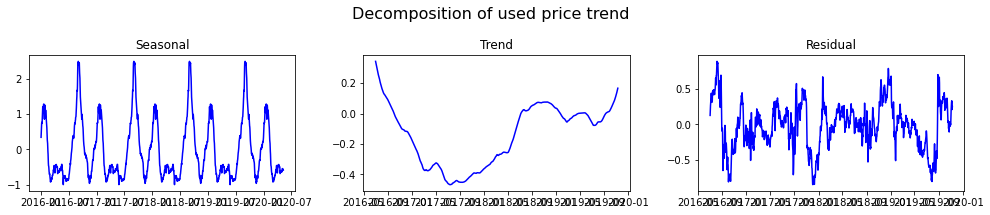

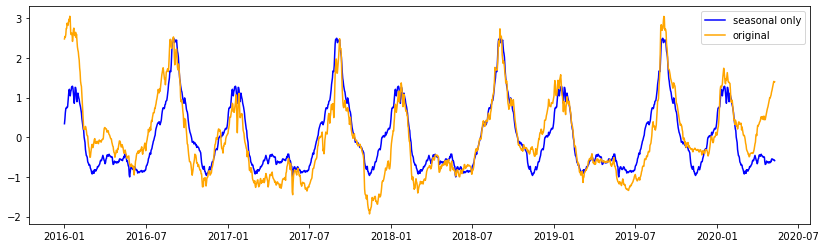

In [11]:
# Plot used price trend
fig = plt.figure(figsize=(14,3))
fig.suptitle('Decomposition of used price trend', fontsize=16)
plt.subplot(1, 3, 1).set_title('Seasonal')
plt.plot(s_up.seasonal,color='blue')
plt.subplot(1, 3, 2).set_title('Trend')
plt.plot(s_up.trend,color='blue')
plt.subplot(1, 3, 3).set_title('Residual')
plt.plot(s_up.resid,color='blue')
plt.tight_layout()

fig = plt.figure(figsize=(14,4))
plt.plot(s_up.seasonal,color='blue')
plt.plot(up_norm,color='orange')
plt.legend(['seasonal only','original'])

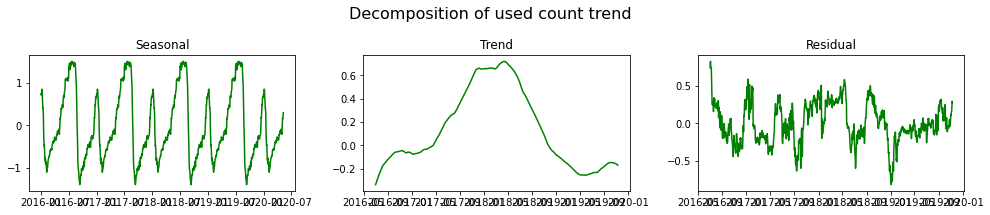

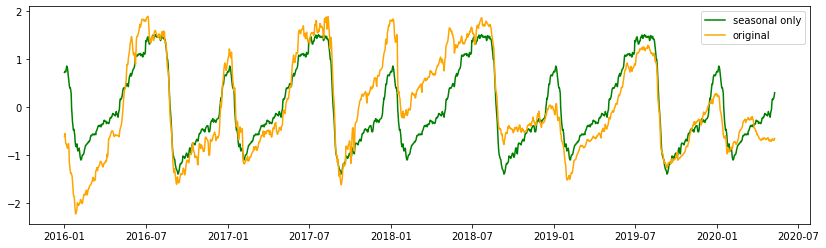

In [12]:
# Plot used count trend
fig = plt.figure(figsize=(14,3))
fig.suptitle('Decomposition of used count trend', fontsize=16)
plt.subplot(1, 3, 1).set_title('Seasonal')
plt.plot(s_uc.seasonal,color='green')
plt.subplot(1, 3, 2).set_title('Trend')
plt.plot(s_uc.trend,color='green')
plt.subplot(1, 3, 3).set_title('Residual')
plt.plot(s_uc.resid,color='green')
plt.tight_layout()

fig = plt.figure(figsize=(14,4))
plt.plot(s_uc.seasonal,color='green')
plt.plot(uc_norm,color='orange')
plt.legend(['seasonal only','original'])

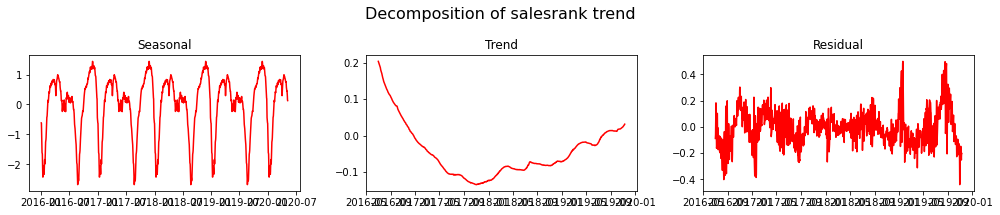

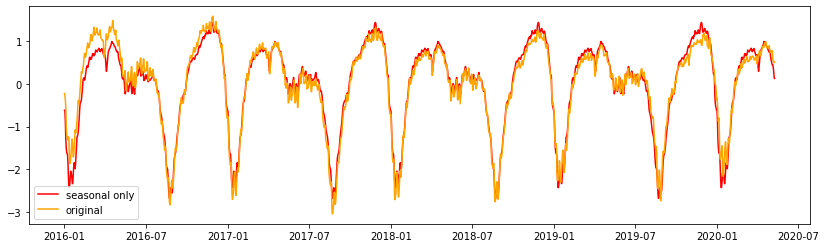

In [13]:
# Plot salesrank trend
fig = plt.figure(figsize=(14,3))
fig.suptitle('Decomposition of salesrank trend', fontsize=16)
plt.subplot(1, 3, 1).set_title('Seasonal')
plt.plot(s_sr.seasonal,color='red')
plt.subplot(1, 3, 2).set_title('Trend')
plt.plot(s_sr.trend,color='red')
plt.subplot(1, 3, 3).set_title('Residual')
plt.plot(s_sr.resid,color='red')
plt.tight_layout()

fig = plt.figure(figsize=(14,4))
plt.plot(s_sr.seasonal,color='red')
plt.plot(sr_norm,color='orange')
plt.legend(['seasonal only','original'])

#### View comparison between statsmodels and plain averages


MSE, used price, statsmodels vs 1yr average : 0.022749892445501796
MSE, used count, statsmodels vs 1yr average : 0.02821395833484243
MSE, salesrank, statsmodels vs 1yr average : 0.009921422769362356


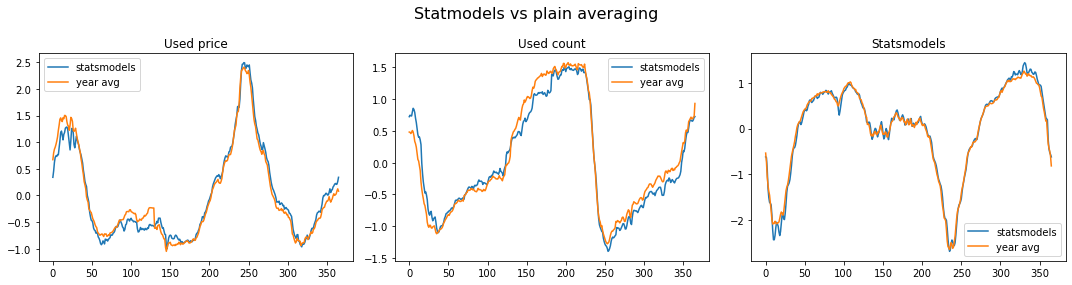

In [14]:
s_up_yr_statsmodels = s_up.seasonal[0:366]
s_uc_yr_statsmodels = s_uc.seasonal[0:366]
s_sr_yr_statsmodels = s_sr.seasonal[0:366]

fig = plt.figure(figsize=(15,4))
fig.suptitle('Statmodels vs plain averaging', fontsize=16)
plt.subplot(1, 3, 1).set_title('Used price')
plt.plot(np.arange(len(s_up_yr_statsmodels)),s_up_yr_statsmodels)
plt.plot(np.arange(len(up_year)),up_year)
plt.legend(['statsmodels','year avg'])
plt.subplot(1, 3, 2).set_title('Used count')
plt.plot(np.arange(len(s_uc_yr_statsmodels)),s_uc_yr_statsmodels)
plt.plot(np.arange(len(uc_year)),uc_year)
plt.legend(['statsmodels','year avg'])
plt.subplot(1, 3, 3).set_title('Statsmodels')
plt.plot(np.arange(len(s_sr_yr_statsmodels)),s_sr_yr_statsmodels)
plt.plot(np.arange(len(sr_year)),sr_year)
plt.legend(['statsmodels','year avg'])
plt.tight_layout()


'''
df_up = pd.DataFrame()
# technically this should work, and avoids reindexing up_year, but it creates all NaNs: 
#df_up['yr_avg'] = up_year.reindex(index=s_up.seasonal.index[0:len(up_year)])
up_year.index = s_up.seasonal.index[0:len(up_year)]
df_up['yr_avg'] = up_year

df_uc = pd.DataFrame(s_uc.seasonal[0:366])
uc_year.index = s_uc.seasonal.index[0:len(uc_year)]
df_uc['yr_avg'] = uc_year

df_sr = pd.DataFrame(s_sr.seasonal[0:366])
sr_year.index = s_sr.seasonal.index[0:len(sr_year)]
df_sr['yr_avg'] = sr_year


fig = plt.figure(figsize=(15,4))
fig.suptitle('Statmodels vs plain averaging', fontsize=16)
plt.subplot(1, 3, 1).set_title('Used price')
plt.plot(df_up)
plt.legend(['statsmodels','year avg'])
plt.subplot(1, 3, 2).set_title('Used count')
plt.plot(df_uc)
plt.legend(['statsmodels','year avg'])
plt.subplot(1, 3, 3).set_title('Statsmodels')
plt.plot(df_sr)
plt.legend(['statsmodels','year avg'])
plt.tight_layout()
'''

# Show MSE
from sklearn.metrics import mean_squared_error

print('MSE, used price, statsmodels vs 1yr average : '\
      + str(mean_squared_error(up_year,s_up.seasonal[0:len(up_year)])))

print('MSE, used count, statsmodels vs 1yr average : '\
      + str(mean_squared_error(uc_year,s_uc.seasonal[0:len(uc_year)])))

print('MSE, salesrank, statsmodels vs 1yr average : '\
      + str(mean_squared_error(sr_year,s_sr.seasonal[0:len(sr_year)])))


### Check MSE of data vs ideal trend for each method

Used price
MSE, data & year avg:0.2662422840328698
MSE, data & statsmodels: 0.29119462341585567
Used count
MSE, data & year avg: 0.2706149582611628
MSE, data & statsmodels: 0.30319969646882594
Salesrank
MSE, data & year avg: 0.2662422840328698
MSE, data & statsmodels: 0.29119462341585567


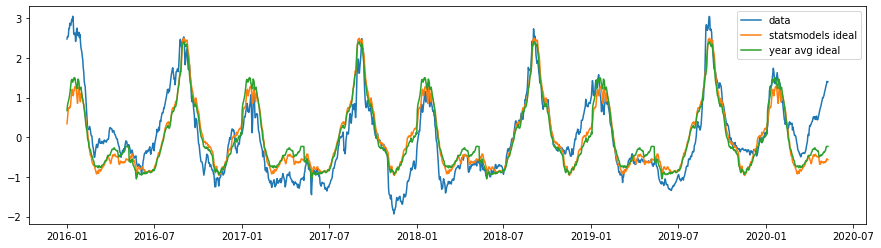

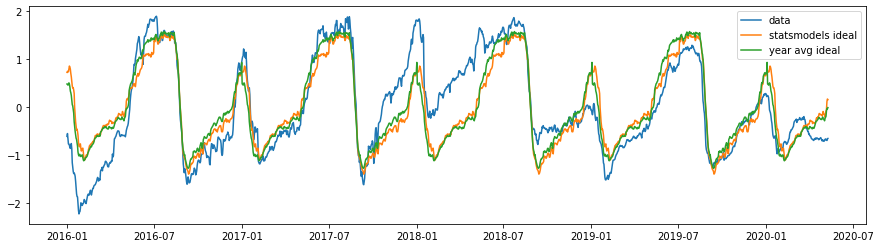

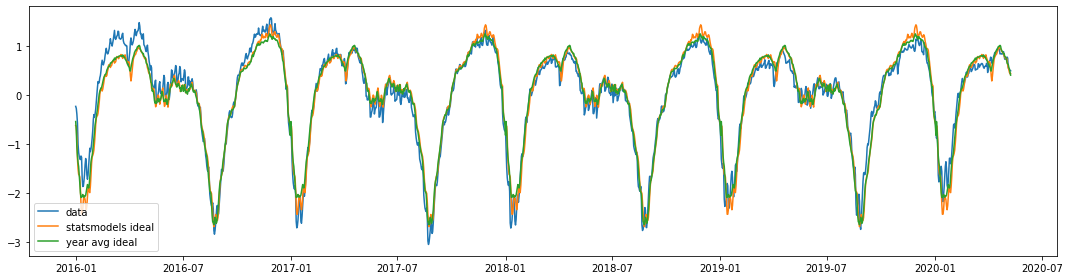

In [15]:

#rep_partial_years(sr_year,np.zeros(1591))
fig = plt.figure(figsize=(15,4))
#fig.suptitle('Real trend evaluated against statsmodels and plain averaging', fontsize=16)
#plt.subplot(3, 1, 1).set_title('Used price')
plt.plot(up_norm)
plt.plot(bnn.rep_partial_years(s_up_yr_statsmodels,up_norm))
plt.plot(bnn.rep_partial_years(up_year,up_norm))
plt.legend(['data','statsmodels ideal','year avg ideal'])



fig = plt.figure(figsize=(15,4))
#plt.subplot(3, 1, 2).set_title('Used count')
plt.plot(uc_norm)
plt.plot(bnn.rep_partial_years(s_uc_yr_statsmodels,uc_norm))
plt.plot(bnn.rep_partial_years(uc_year,uc_norm))
plt.legend(['data','statsmodels ideal','year avg ideal'])



fig = plt.figure(figsize=(15,4))
#plt.subplot(3, 1, 3).set_title('Statsmodels')
plt.plot(sr_norm)
plt.plot(bnn.rep_partial_years(s_sr_yr_statsmodels,sr_norm))
plt.plot(bnn.rep_partial_years(sr_year,sr_norm))
plt.legend(['data','statsmodels ideal','year avg ideal'])
plt.tight_layout()


print('Used price')
print('MSE, data & year avg:' + \
      str(mean_squared_error(bnn.rep_partial_years(up_year,up_norm),up_norm)))
print('MSE, data & statsmodels: ' + \
      str(mean_squared_error(bnn.rep_partial_years(s_up_yr_statsmodels,up_norm),up_norm)))

print('Used count')
print('MSE, data & year avg: ' + \
      str(mean_squared_error(bnn.rep_partial_years(uc_year,uc_norm),uc_norm)))
print('MSE, data & statsmodels: ' + \
      str(mean_squared_error(bnn.rep_partial_years(s_uc_yr_statsmodels,uc_norm),uc_norm)))

print('Salesrank')
print('MSE, data & year avg: ' + \
      str(mean_squared_error(bnn.rep_partial_years(up_year,up_norm),up_norm)))
print('MSE, data & statsmodels: ' + \
      str(mean_squared_error(bnn.rep_partial_years(s_up_yr_statsmodels,up_norm),up_norm)))

In [16]:
# Save single year trends to csv

up_year.to_csv('./stats/up_year.csv')
uc_year.to_csv('./stats/uc_year.csv')
sr_year.to_csv('./stats/sr_year.csv')

s_up_yr_statsmodels.to_csv('./stats/up_year_sm.csv')
s_uc_yr_statsmodels.to_csv('./stats/uc_year_sm.csv')
s_sr_yr_statsmodels.to_csv('./stats/sr_year_sm.csv')
